In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0" :
  raise SystemError("GPU device not found")
print("Found GPU at : {}".format(device_name))

def xavier_init(size) :
  in_dim = size[0]
  xavier_stddev = 1./ tf.sqrt(in_dim/2.)
  return tf.random_normal(shape=size , stddev =xavier_stddev)



Found GPU at : /device:GPU:0


In [0]:
img_size = 28*28
z_dim = 16
c_dim = 10
dim_sum = 30
hidden_1 =256
hidden_q = 128
batch_size=100
learning_rate =0.001
smooth = 0.1


X = tf.placeholder(tf.float32 , shape=[None ,img_size])
Z = tf.placeholder(tf.float32 , shape=[None, z_dim])
C = tf.placeholder(tf.float32 , shape=[None, c_dim])
a = tf.contrib.layers.xavier_initializer()

In [0]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def sample_c(m):
    return np.random.multinomial(1, 10*[0.1], size=m)

def generator(z , c) :
  with tf.device("/gpu:0") :
    with tf.variable_scope("generator") as scope :
      inputs =  tf.concat(axis=1 , values =[ z, c])
      hidden = tf.layers.dense(inputs , hidden_1 , activation=tf.nn.relu, use_bias=True,
                               kernel_initializer=a )
      output = tf.layers.dense(hidden, img_size, activation = tf.nn.sigmoid, use_bias=True,
                               kernel_initializer=a )
      return output
    
def discriminator(x) :
  with tf.device("/gpu:0") :
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE) as scope:
      hidden_d = tf.layers.dense(x , hidden_1 , activation=tf.nn.relu , use_bias=True, 
                                kernel_initializer=a )
      logit = tf.layers.dense(hidden_d , 1 , activation =None , use_bias =True ,
                                kernel_initializer=a )
      prob = tf.nn.sigmoid(logit)
      
      return prob, logit
      
def Q(x) :
  with tf.device("/gpu:0") :
    with tf.variable_scope("q" )  as scope :
      hidden_2 = tf.layers.dense(x, hidden_q , activation=tf.nn.relu , use_bias=True ,
                            kernel_initializer=a )
      output_q = tf.layers.dense(hidden_2 , c_dim , activation = tf.nn.softmax , use_bias=True ,
                            kernel_initializer=a )
  return output_q


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [0]:
G_sample = generator(Z, C)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)
Q_C_GIVEN_X = Q(G_sample)


In [5]:


mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)



Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


## 결과 값이 아주 엉망으로 나옴

이렇게 loss를 사용하니 결과가 처참함
```
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits =D_logit_real, labels =tf.ones_like(D_logit_real)*0.9))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits =D_logit_fake, labels =tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits =D_logit_fake, labels =tf.ones_like(D_logit_fake)))
```





In [0]:

D_loss = -tf.reduce_mean(tf.log(D_real + 1e-8) + tf.log(1 - D_fake + 1e-8))
G_loss = -tf.reduce_mean(tf.log(D_fake + 1e-8))

cross_ent = tf.reduce_mean(-tf.reduce_sum(tf.log(Q_C_GIVEN_X +1e-8)*C , 1)) # H(C|G(Z,C))
ent = tf.reduce_mean(-tf.reduce_sum(tf.log(C+1e-8)*C , 1)) # H(C)
Q_loss= cross_ent +ent

vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator' )
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="generator")
vars_Q = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="q")

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=vars_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=vars_G)
Q_solver = tf.train.AdamOptimizer().minimize(Q_loss, var_list=vars_G + vars_Q)
                          

Iter: 0
D loss: 1.654
G_loss: 2.842
------------------------------------
Iter: 10000
D loss: 0.2681
G_loss: 3.266
------------------------------------


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iter: 20000
D loss: 0.4704
G_loss: 2.662
------------------------------------
Iter: 30000
D loss: 0.6265
G_loss: 2.449
------------------------------------
Iter: 40000
D loss: 0.4958
G_loss: 2.391
------------------------------------
Iter: 50000
D loss: 0.417
G_loss: 2.683
------------------------------------
Iter: 60000
D loss: 0.5706
G_loss: 2.255
------------------------------------
Iter: 70000
D loss: 0.5019
G_loss: 2.389
------------------------------------
Iter: 80000
D loss: 0.6015
G_loss: 2.307
------------------------------------
Iter: 90000
D loss: 0.7389
G_loss: 1.962
------------------------------------


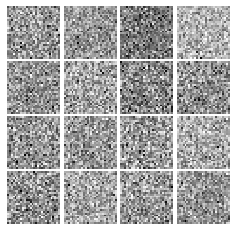

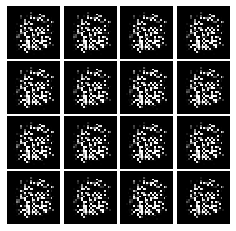

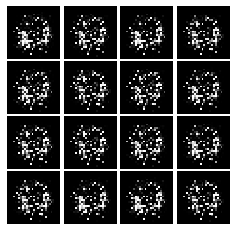

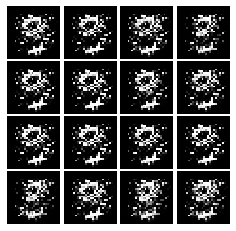

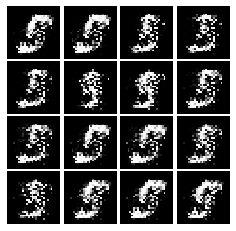

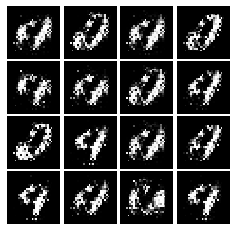

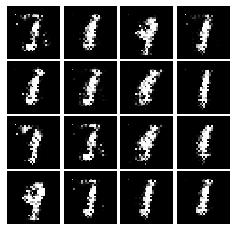

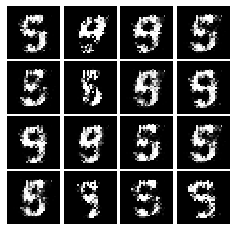

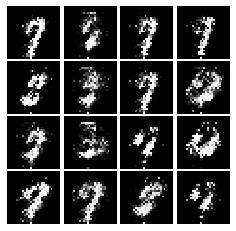

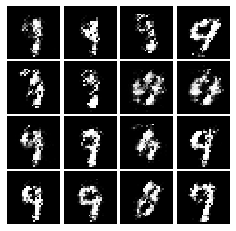

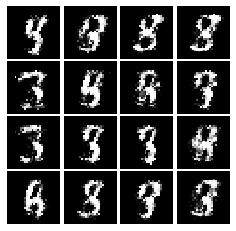

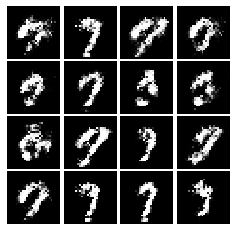

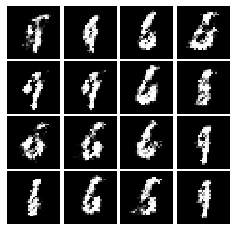

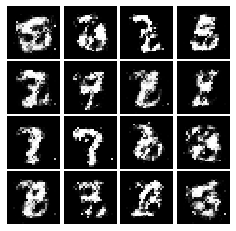

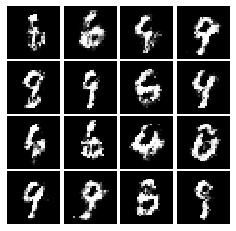

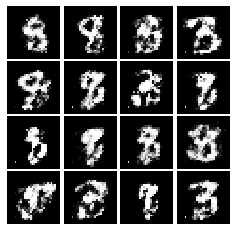

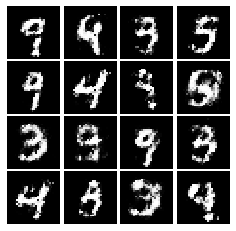

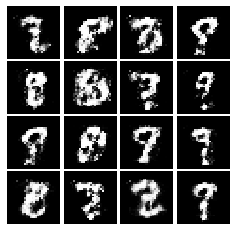

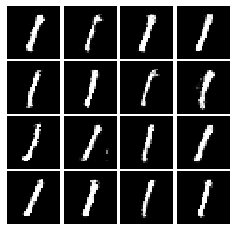

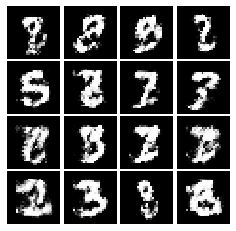

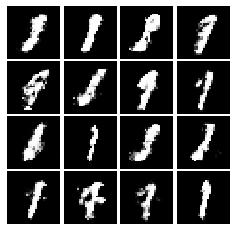

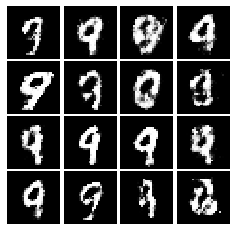

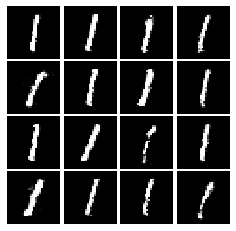

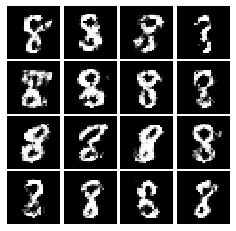

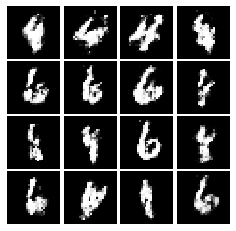

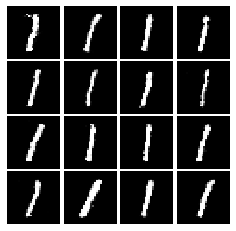

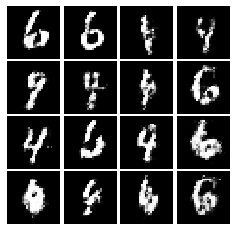

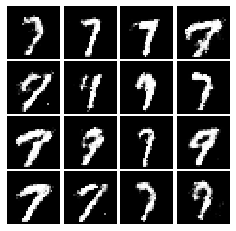

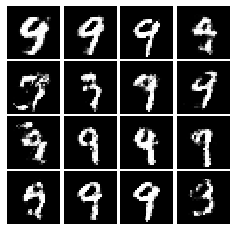

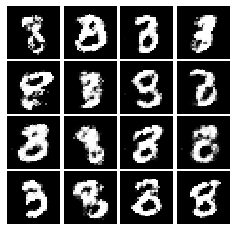

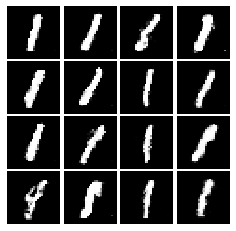

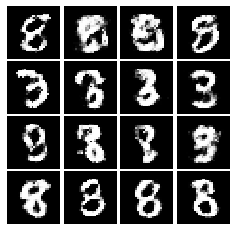

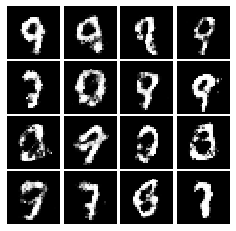

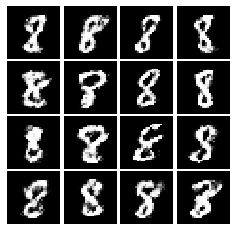

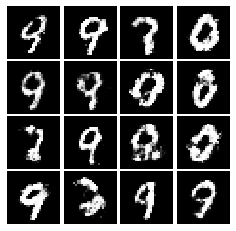

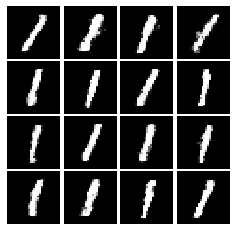

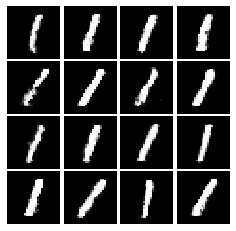

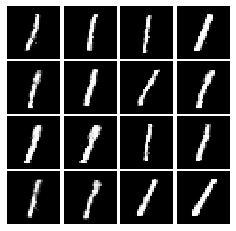

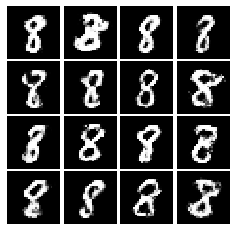

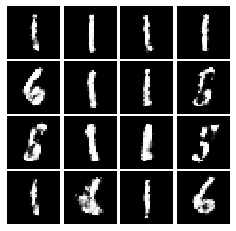

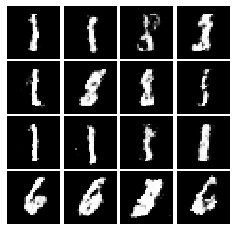

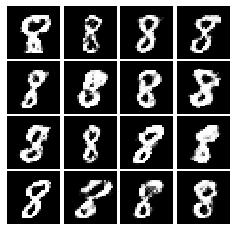

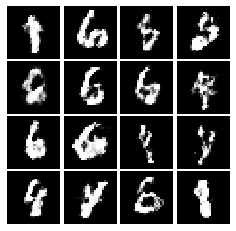

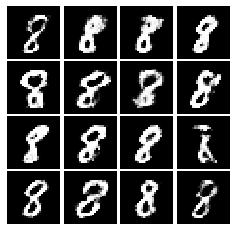

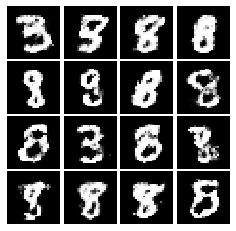

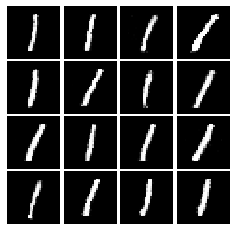

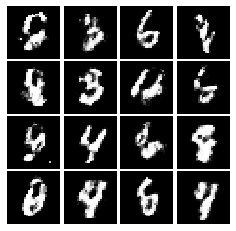

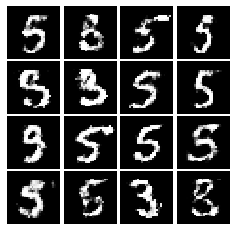

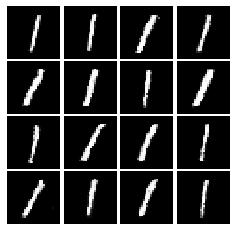

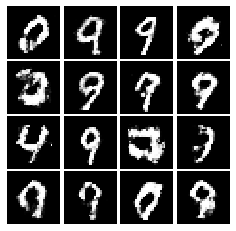

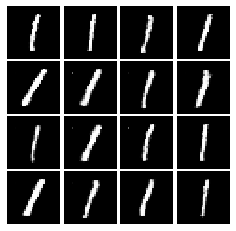

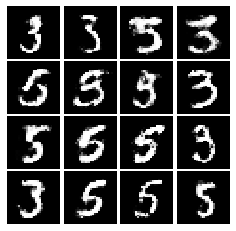

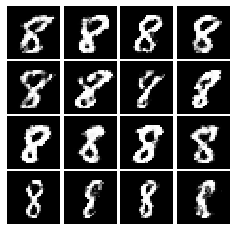

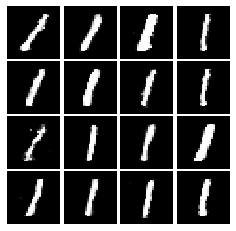

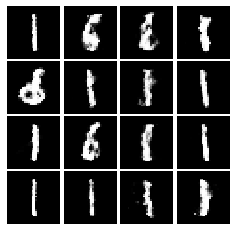

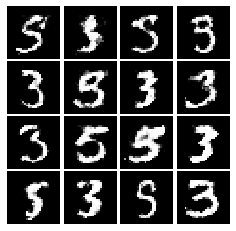

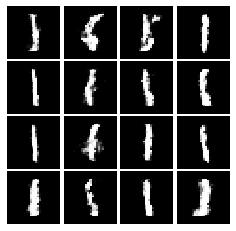

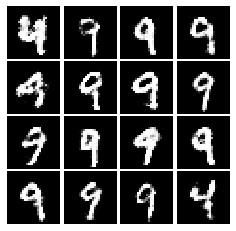

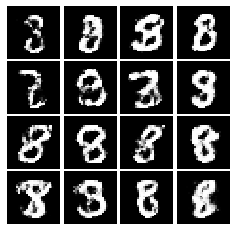

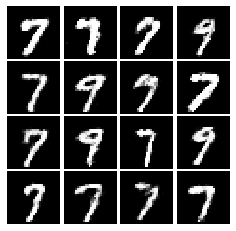

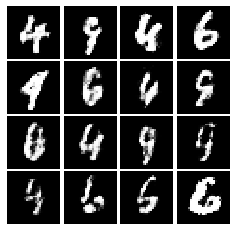

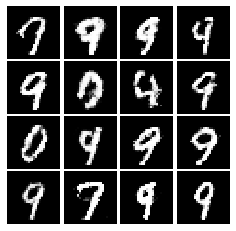

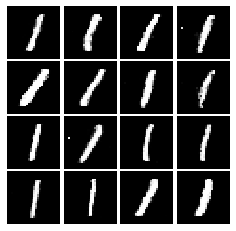

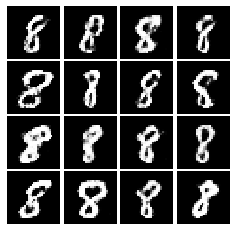

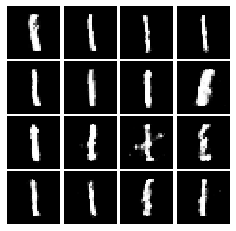

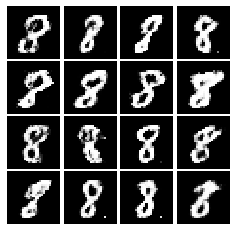

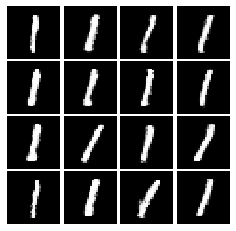

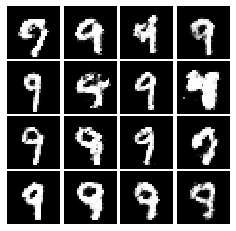

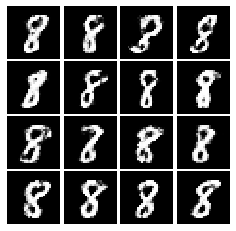

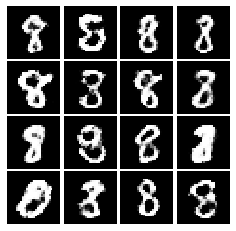

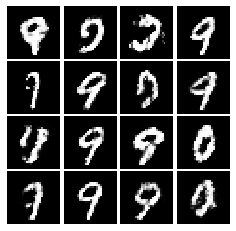

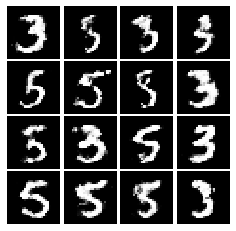

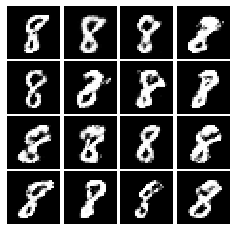

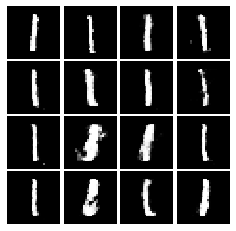

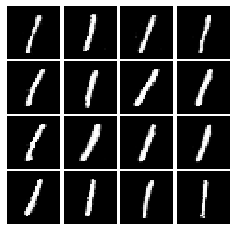

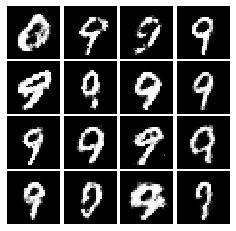

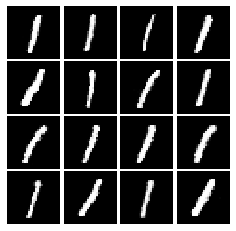

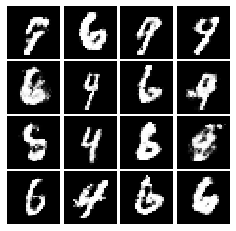

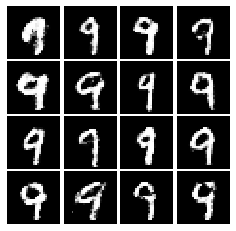

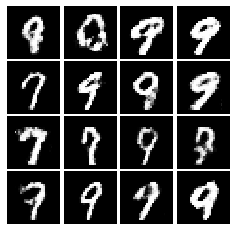

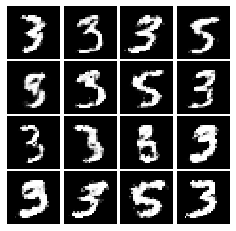

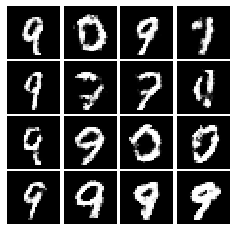

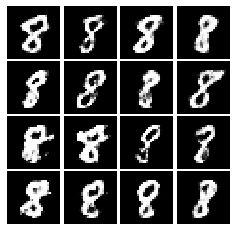

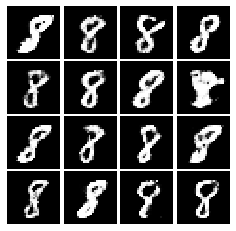

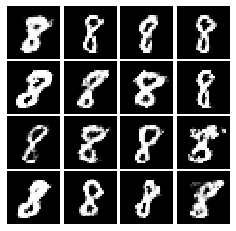

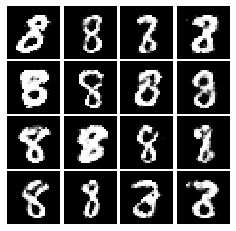

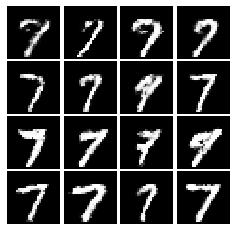

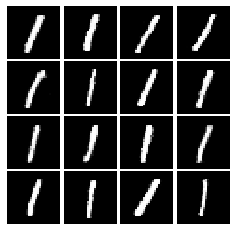

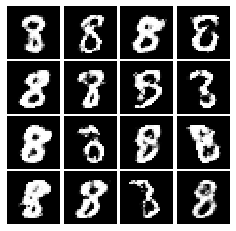

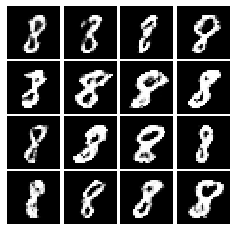

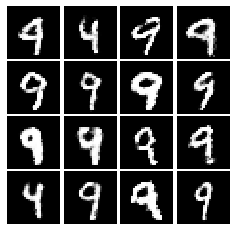

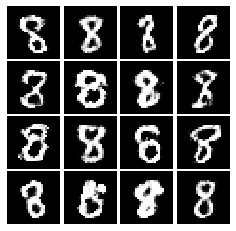

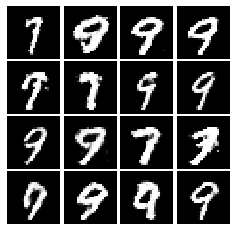

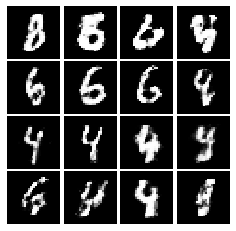

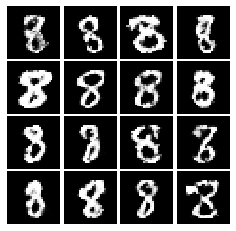

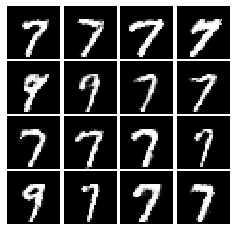

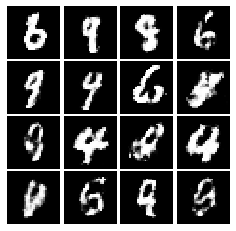

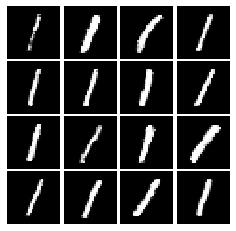

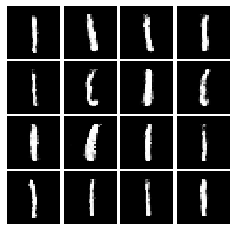

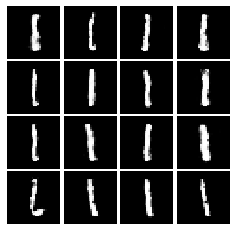

In [7]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
mb_size=32
i = 0

for it in range(100000):
    if it % 1000 == 0:
        Z_noise = sample_Z(16, z_dim)

        idx = np.random.randint(0, c_dim)
        c_noise = np.zeros([16, c_dim])
        c_noise[range(16), idx] = 1

        samples = sess.run(G_sample,
                           feed_dict={Z: Z_noise, C: c_noise})

        fig = plot(samples)
        plt.savefig('{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        # plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_noise = sample_Z(mb_size, z_dim)
    c_noise = sample_c(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss],
                              feed_dict={X: X_mb, Z: Z_noise, C: c_noise})

    _, G_loss_curr = sess.run([G_solver, G_loss],
                              feed_dict={Z: Z_noise, C: c_noise})

    sess.run([Q_solver], feed_dict={Z: Z_noise, C: c_noise})

    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print("------------------------------------")